# Time Series Forecasting using Facebook's Prophet

In [1]:
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from fbprophet import Prophet
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [19]:
def dataPreprocessing(clusterName, metrics = ['cpu']):
    orignalDf = pd.read_csv('../input/'+clusterName+'.csv')
    orignalDf['date'] = 0
    for i in range(len(orignalDf.timestamps)):
        orignalDf['date'][i] = datetime.datetime.fromtimestamp(orignalDf.timestamps[i]/1000.0).strftime('%Y-%m-%d')
    orignalDf.drop(columns = ['timestamps', 'Unnamed: 0'], inplace = True)
    orignalDf['date']=pd.to_datetime(orignalDf['date'])
    dfForProphet = orignalDf.copy()
    dropMetrics = [metric for metric in orignalDf.columns if metric not in metrics and metric != 'date']
    dfForProphet.drop(columns = dropMetrics, inplace=True)
    dfForProphet.rename(columns = {'date':'ds', 'cpu':'y'}, inplace=True)
    orignalDf.set_index('date',inplace=True)
    return orignalDf, dfForProphet

def createFeatures(df, metric='cpu'):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    y = df[metric]
    return X, y

def plotCreatedFeature(df, metric='cpu'):
    X, y = createFeatures(df, metric='cpu')
    features_and_target = pd.concat([X, y], axis=1)
    features_and_target.head()
    sns.pairplot(features_and_target.dropna(),hue='hour', x_vars=['hour','dayofweek','year','weekofyear'],y_vars='cpu',height=5,plot_kws={'alpha':0.15, 'linewidth':0})
    plt.suptitle(metric+' usage by Hour, Day of Week, Year and Week of Year')
    plt.show()
        
def splitData(df, days = 153, trainSize = 0.8):
    training_data_length = int(days*trainSize)
    X_train = df[:training_data_length]
    X_test = df[training_data_length:days]
    return X_train, X_test

def removeOutliers(df, fromToDate):
    for fromDate, toDate in fromToDate:
        df.loc[(df['ds'] > fromDate) & (df['ds'] < toDate), 'y'] = None
    return df

def plotData(X, y, labels):
    colors = ['blue', 'green', 'red', 'magenta', 'black', 'cyan', 'yellow']
    random.shuffle(colors)
    plt.figure(figsize = (25, 8))
    for i in range(len(X)):
        plt.plot(X[i], y[i], color = colors[i], label = labels[i], marker='o')
        plt.xlabel('Date', fontsize = 20)
        if len(labels) == 1:
            plt.title(labels[0], fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

    
def prophet(X_train, forecastLength, dailySeasonality=False, yearlySeasonality = False, holidayEffect = False):
    if holidayEffect:
        cal = calendar()
        train_holidays = cal.holidays(start = X_train.index.min(), end = X_train.index.max())
        X_train['is_holiday'] = X_train.ds.isin([d.date() for d in cal.holidays()])
        holiday_df = X_train.loc[X_train['is_holiday']]
        holiday_df['holiday'] = 'USFederalHoliday'
        holiday_df = holiday_df.drop(['is_holiday'], axis=1)
        holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])
        model_with_holidays = Prophet(holidays = holiday_df, daily_seasonality = dailySeasonality, yearly_seasonality = yearlySeasonality)
        model_with_holidays.fit(X_train)
        futureDates = model_with_holidays.make_future_dataframe(periods = forecastLength)
        forecast = model_with_holidays.predict(futureDates[len(X_train):])
        print('Plot for various components of the series')
        model_with_holidays.plot_components(forecast)
    else:
        model = Prophet(daily_seasonality = dailySeasonality, yearly_seasonality = yearlySeasonality)
        model.fit(X_train)
        futureDates = model.make_future_dataframe(periods = forecastLength)
        forecast = model.predict(futureDates[len(X_train):])
        print('Plot for various components of the series')
        model.plot_components(forecast)
    return forecast

def calculateError(X_test, forecast):
    print('Mean Squared error between X_test and yhat_lower is: ', mean_squared_error(y_true = X_test['y'], y_pred = forecast['yhat_lower']))
    print('Mean Absolute error between X_test and yhat_lower is: ', mean_absolute_error(y_true = X_test['y'], y_pred = forecast['yhat_lower']))
    print('\n')
    print('Mean Squared error between X_test and yhat is: ', mean_squared_error(y_true = X_test['y'], y_pred = forecast['yhat']))
    print('Mean Absolute error between X_test and yhat is: ', mean_absolute_error(y_true = X_test['y'], y_pred = forecast['yhat']))
    print('\n')
    print('Mean Squared error between X_test and yhat_upper is: ', mean_squared_error(y_true = X_test['y'], y_pred = forecast['yhat_upper']))
    print('Mean Absolute error between X_test and yhat_upper is: ', mean_absolute_error(y_true = X_test['y'], y_pred = forecast['yhat_upper']))
    
def timeSeriesUsingProphet(clusterName, metric, days, trainSize, forecastLength, fromToDate = [('2019-10-15', '2019-10-24'), ('2019-11-17', '2019-11-26')], dailySeasonality=False, yearlySeasonality=False, holidayEffect=False, testDataAvailable=True):
    originalDf, dfForProphet = dataPreprocessing(clusterName, metric)
    plotCreatedFeature(originalDf, metric)
    X_train, X_test = splitData(dfForProphet, days=153, trainSize=0.8)
    X_train = removeOutliers(X_train, fromToDate)
    plotData([X_train.ds, X_test.ds], [X_train.y, X_test.y], labels = ['trainingData', 'testData'])
    forecast = prophet(X_train, forecastLength, dailySeasonality, yearlySeasonality, holidayEffect)
    plotData([X_test.ds, X_test.ds], [X_test.y, forecast['yhat_lower']], labels = ['testData', 'lowerForecast'])
    plotData([X_test.ds, X_test.ds], [X_test.y, forecast['yhat']], labels = ['testData', 'forecast'])
    plotData([X_test.ds, X_test.ds], [X_test.y, forecast['yhat_upper']], labels = ['testData', 'upperForecast'])
    if testDataAvailable:
        calculateError(X_test, forecast)

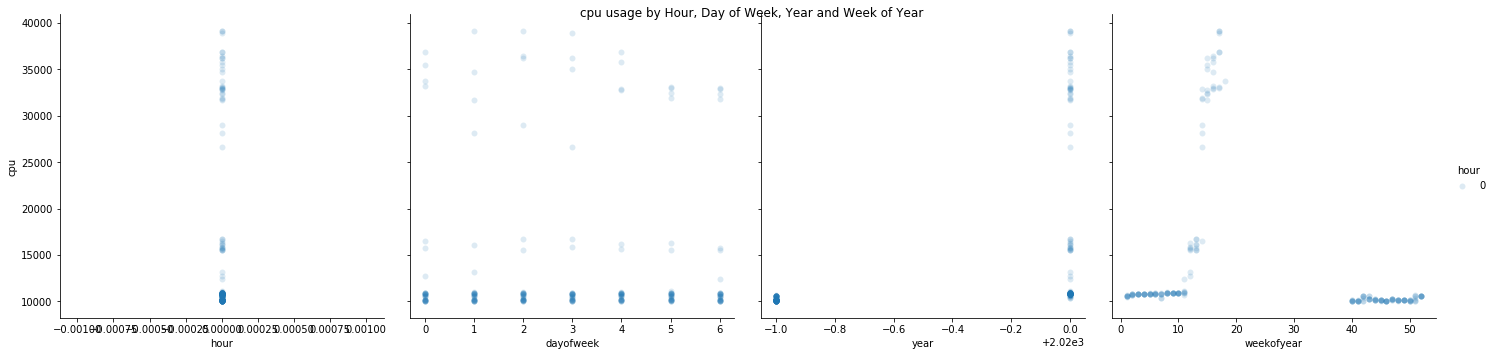

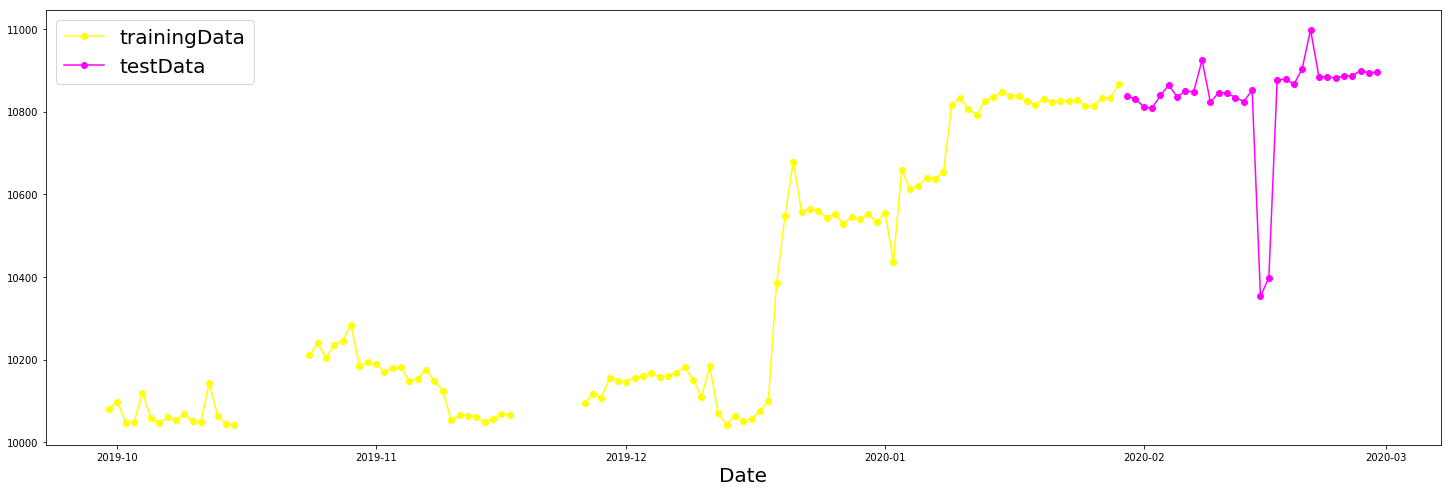

              y         ds  is_holiday
0  10080.829557 2019-09-30       False
1  10097.263431 2019-10-01       False
2  10047.982639 2019-10-02       False
3  10050.055318 2019-10-03       False
4  10120.385206 2019-10-04       False
Plot for various components of the series


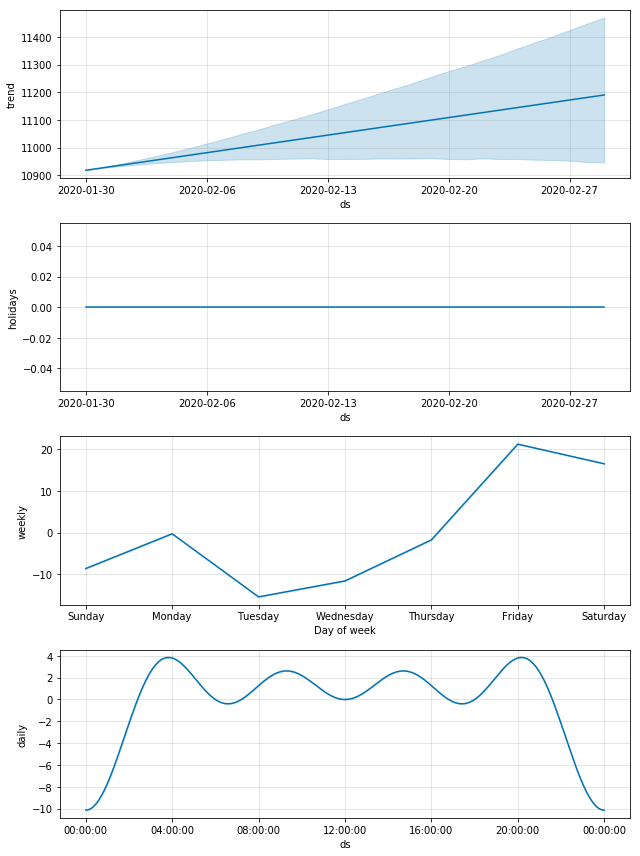

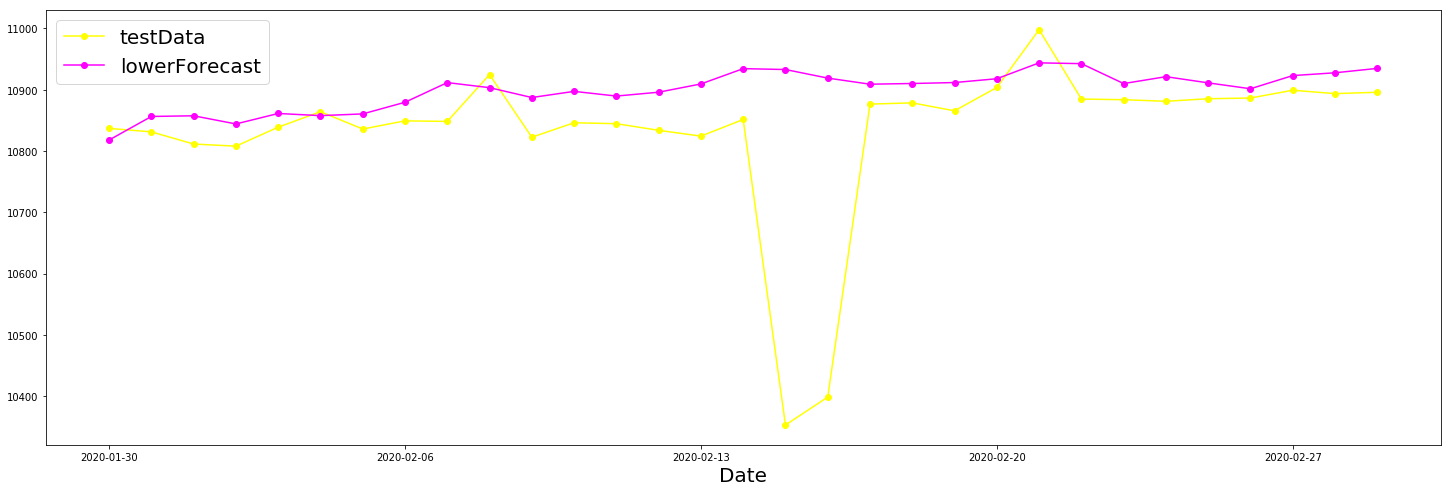

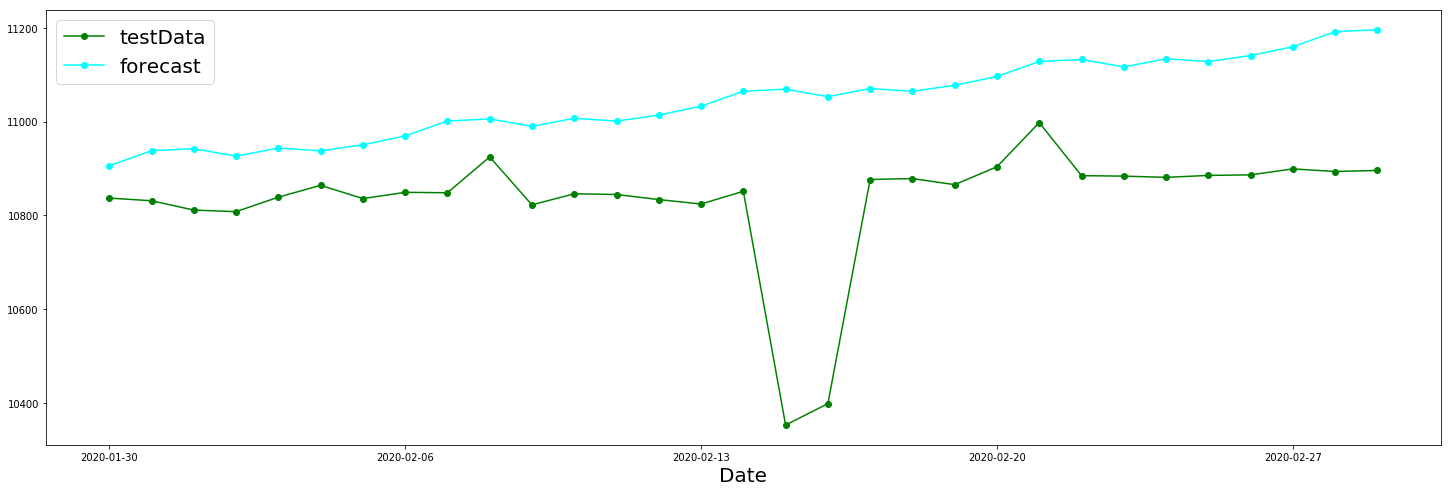

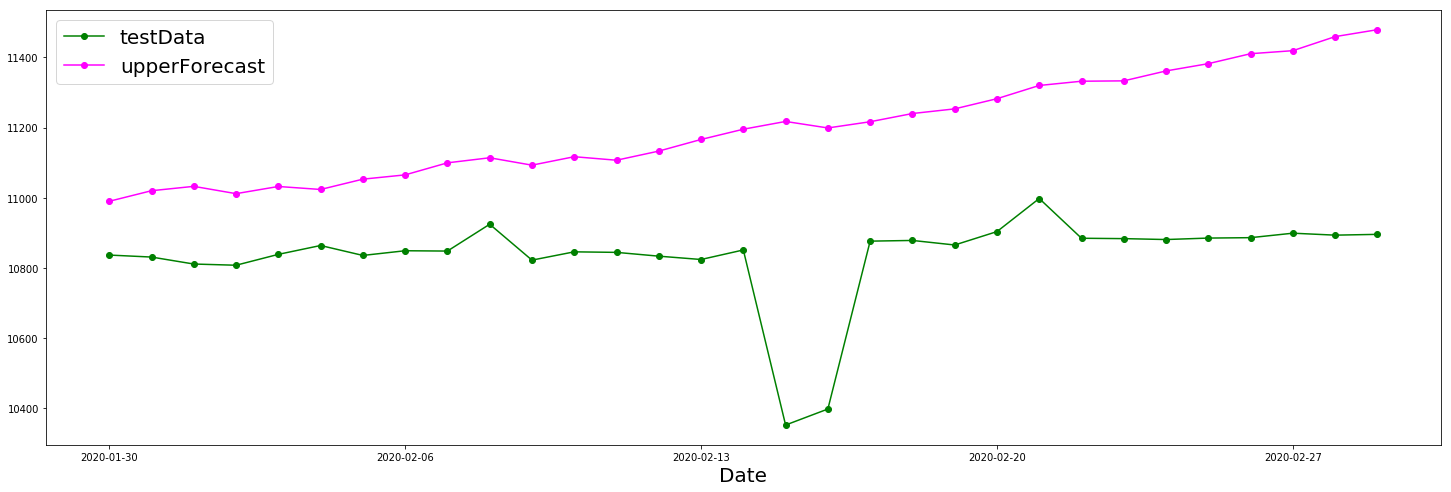

Mean Squared error between X_test and yhat_lower is:  21376.463401148896
Mean Absolute error between X_test and yhat_lower is:  71.87395658944537


Mean Squared error between X_test and yhat is:  64054.13009879401
Mean Absolute error between X_test and yhat is:  210.88101977190908


Mean Squared error between X_test and yhat_upper is:  163296.31135815446
Mean Absolute error between X_test and yhat_upper is:  364.6679915756786


In [20]:
timeSeriesUsingProphet('AMS01-TVPP1-CloudCenter-Cluster', 'cpu', 153, 0.8, 31, dailySeasonality=True, holidayEffect=True)